In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
import tensorflow as tf
print(tf.__version__)


2.10.0


In [3]:
!pip install plotly

In [4]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

from sklearn.model_selection import train_test_split

In [5]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [6]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [7]:
train_data = train_df('D:\Mahir\Datasets\Merged Dataset 1\Training')

In [8]:
train_data


,Class Path,Class
0,D:\Mahir\Datasets\Merged Dataset 1\Training\gl...,glioma
1,D:\Mahir\Datasets\Merged Dataset 1\Training\gl...,glioma
2,D:\Mahir\Datasets\Merged Dataset 1\Training\gl...,glioma
3,D:\Mahir\Datasets\Merged Dataset 1\Training\gl...,glioma
4,D:\Mahir\Datasets\Merged Dataset 1\Training\gl...,glioma
...,...,...
5707,D:\Mahir\Datasets\Merged Dataset 1\Training\pi...,pituitary
5708,D:\Mahir\Datasets\Merged Dataset 1\Training\pi...,pituitary
5709,D:\Mahir\Datasets\Merged Dataset 1\Training\pi...,pituitary
5710,D:\Mahir\Datasets\Merged Dataset 1\Training\pi...,pituitary


In [9]:
test_data = test_df('D:\Mahir\Datasets\Merged Dataset 1\Testing')

In [10]:
test_data

,Class Path,Class
0,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
1,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
2,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
3,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
4,D:\Mahir\Datasets\Merged Dataset 1\Testing\gli...,glioma
...,...,...
1306,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary
1307,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary
1308,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary
1309,D:\Mahir\Datasets\Merged Dataset 1\Testing\pit...,pituitary


In [11]:
train_path = 'D:\Mahir\Datasets\Merged Dataset 1\Training'
test_path = 'D:\Mahir\Datasets\Merged Dataset 1\Testing'

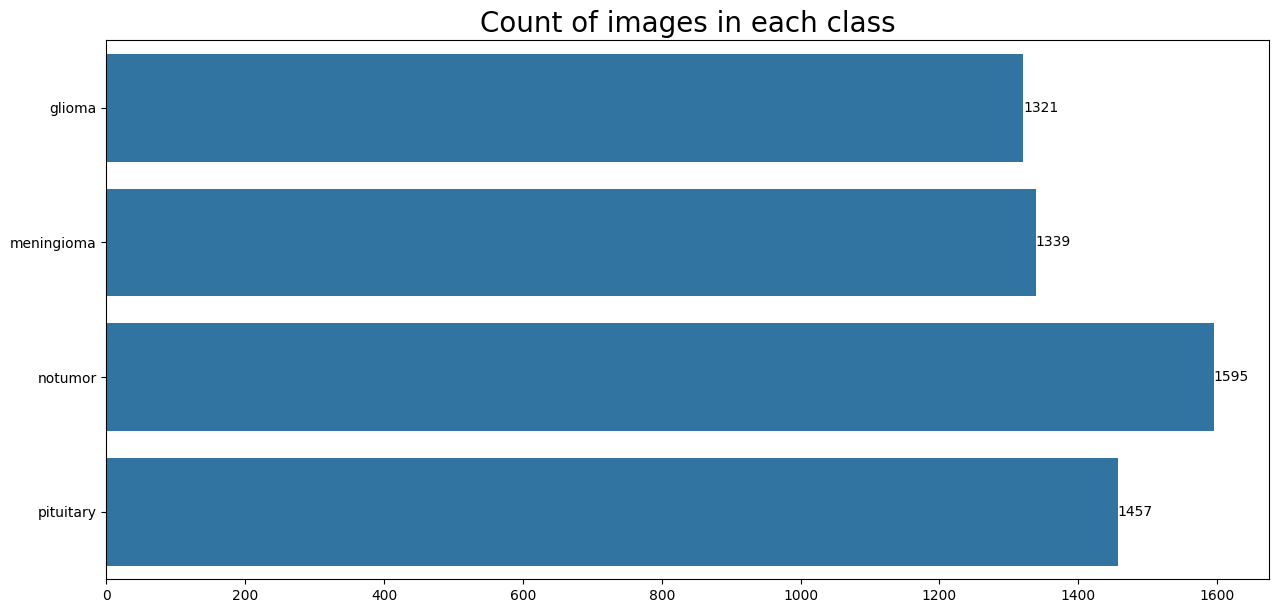

In [12]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_data , y=train_data ['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

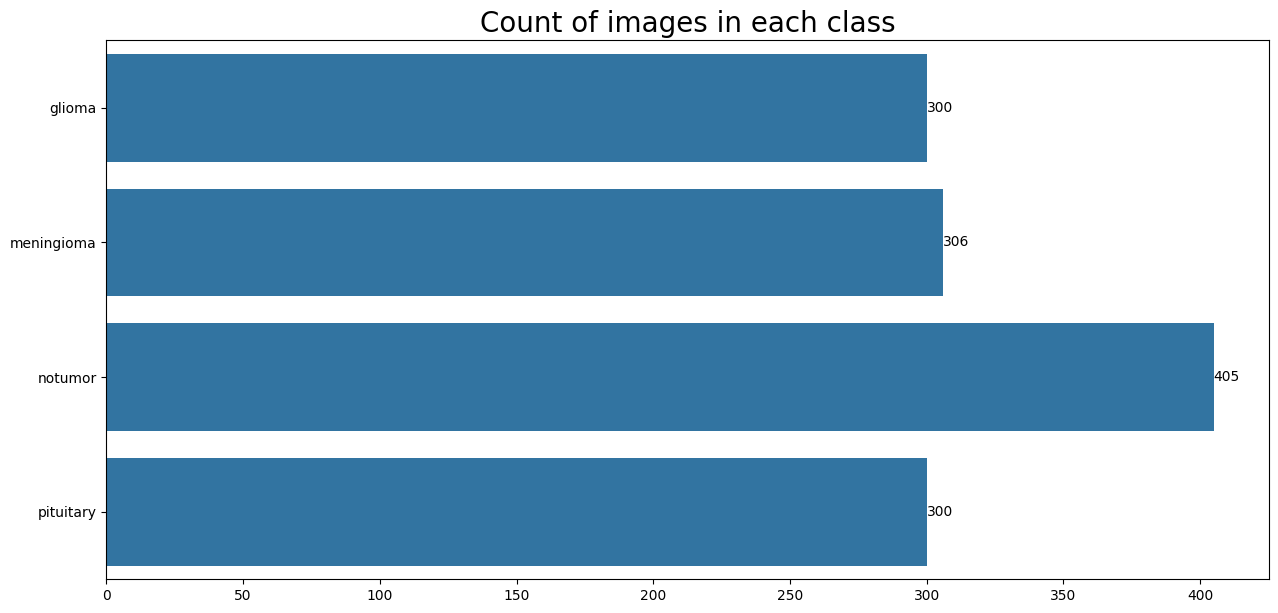

In [13]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=test_data , y=test_data ['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()


In [14]:
# Image size
image_size = (160, 160)

# Training batch size
batch_size = 32

In [15]:
# Data preprocessing without any augmentation, only rescaling and validation split
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

# Creating training data generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(160, 160),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    seed=0)

# Creating validation data generator
val_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(160, 160),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  subset='validation',
                                                 shuffle=False,
                                                  seed=0)

# Applying the generator to testing data, only rescaling
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(160, 160),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  subset='training',  # Uses the other 50% intended for testing
                                                  shuffle=False)

Found 5712 images belonging to 4 classes.
Found 655 images belonging to 4 classes.
Found 656 images belonging to 4 classes.


In [16]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    # Use __next__() instead of next()
    augmented_samples = train_generator.__next__()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

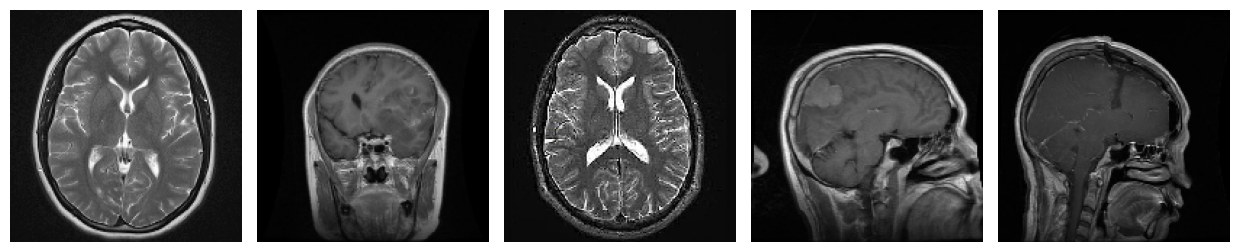

In [17]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=False)


In [18]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)


print(f'Image shape: {image_shape}')
print(f'Batch size: {batch_size}')
print(f'Number of Train batches: {len(train_generator)}')
print(f'Number of Validation batches: {len(val_generator)}')
print(f'Number of Testing batches: {len(test_generator)}')

Image shape: (160, 160, 3)
Batch size: 32
Number of Train batches: 179
Number of Validation batches: 21
Number of Testing batches: 21


In [19]:
Classes_Map = train_generator.class_indices

num_classes = len(Classes_Map)

print("Number of Classes:", num_classes)
Classes_Map

Number of Classes: 4


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [20]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')


  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

# VGG16 MODEL - Teacher 1

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))


for layer in base_model_vgg.layers[:-10]:
    layer.trainable = False

for layer in base_model_vgg.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

teacher = Model(inputs=base_model_vgg.input, outputs=output)


teacher.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

teacher.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

num_epochs = 50

early_stopper = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

checkpoint_path = r'D:\Mahir\Brain\Checkpoints\vgg16_no_aug_d1_epoch50_p_7.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

teacher.load_weights(checkpoint_path)

teacher.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [24]:
test_score = teacher.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


21/21 [==============================] - 9s 139ms/step - loss: 0.0787 - accuracy: 0.9802 - precision: 0.9817 - recall: 0.9802
Test Loss: 0.0787
Test Accuracy: 98.02%


In [25]:
preds = teacher.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

21/21 [==============================] - 1s 52ms/step


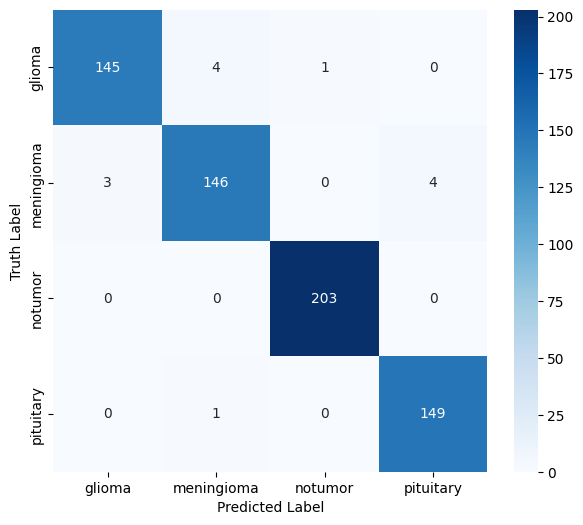

In [26]:

cm = confusion_matrix(test_generator.classes, y_pred)
class_dict = train_generator.class_indices
labels = list(class_dict.keys())
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [27]:
clr = classification_report(test_generator.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       150
           1       0.97      0.95      0.96       153
           2       1.00      1.00      1.00       203
           3       0.97      0.99      0.98       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



### Tiny Resnet - Student 1

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler

def residual_block(x, filters, stride=1, dropout_rate=0.3):
    shortcut = x

    # First convolutional layer with L2 regularization and dropout
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Second convolutional layer with L2 regularization
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)

    # Adjust the shortcut path
    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False,
                                 kernel_regularizer=regularizers.l2(0.001))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Combine and activate
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x
# resnet 2
def build_resnet_student(input_shape=(160, 160, 3), num_classes=4, dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(16, kernel_size=3, strides=1, padding="same", use_bias=False,
                      kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    x = residual_block(x, 16, stride=2, dropout_rate=0.2)
    x = residual_block(x, 16, stride=1, dropout_rate=0.2)
    x = residual_block(x, 32, stride=2, dropout_rate=0.2)
    x = residual_block(x, 32, stride=1, dropout_rate=0.2)
    x = residual_block(x, 64, stride=2, dropout_rate=0.2)
    x = residual_block(x, 64, stride=1, dropout_rate=0.2)

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

student_model = build_resnet_student(num_classes=4)
student_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 16  432         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [29]:
student_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])


In [30]:
def distillation_loss(y_true, y_pred, teacher_pred, temperature=5.0, alpha=0.5):
    # Compute student loss against ground truth
    student_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Compute distillation loss between softened predictions
    teacher_pred_soft = tf.nn.softmax(teacher_pred / temperature)
    y_pred_soft = tf.nn.softmax(y_pred / temperature)
    distill_loss = (
        tf.keras.losses.categorical_crossentropy(teacher_pred_soft, y_pred_soft)
        * temperature**2
    )

    # Combine losses with alpha weighting
    return alpha * student_loss + (1 - alpha) * distill_loss



In [31]:
import math

def train_and_evaluate_model(student_model, teacher_model, train_generator, val_generator, test_generator,
                             epochs=200, temperature=5.0, alpha=0.5, patience=5, save_path="best_model.h5"):
    """
    Train the student model with knowledge distillation, evaluate on test set, and plot metrics.
    """
    for layer in teacher_model.layers:
        layer.trainable = False
        
    optimizer = tf.keras.optimizers.Adam()
    best_val_loss = float('inf')
    patience_counter = 0

    # Metrics storage
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Get the total number of batches based on dataset size and batch size
    total_batches_train = math.ceil(train_generator.samples / train_generator.batch_size)
    total_batches_val = math.ceil(val_generator.samples / val_generator.batch_size)
    total_batches_test = math.ceil(test_generator.samples / test_generator.batch_size)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Training phase
        train_loss = tf.keras.metrics.Mean()
        train_accuracy = tf.keras.metrics.CategoricalAccuracy()

        for iteration, (x_batch_train, y_batch_train) in enumerate(train_generator):
            # Ensure the loop doesn't run beyond the total number of batches
            if iteration >= total_batches_train:
                break

            # Ensure the progress value does not exceed 100%
            progress = min((iteration + 1) / total_batches_train, 1.0)
            bar = '=' * int(progress * 30)  # 30 represents the length of the progress bar
            print(f"Iteration {iteration + 1}/{total_batches_train} [{bar:<30}] {progress * 100:.2f}%", end='\r')

            with tf.GradientTape() as tape:
                student_logits = student_model(x_batch_train, training=True)
                teacher_logits = teacher_model(x_batch_train, training=False)
                loss = distillation_loss(y_batch_train, student_logits, teacher_logits, temperature, alpha)

            grads = tape.gradient(loss, student_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, student_model.trainable_weights))

            train_loss.update_state(loss)
            train_accuracy.update_state(y_batch_train, student_logits)

        print()  # Ensure the progress bar is printed on a new line after each epoch

        # Validation phase
        val_loss = tf.keras.metrics.Mean()
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for iteration, (x_batch_val, y_batch_val) in enumerate(val_generator):
            # Ensure the loop doesn't run beyond the total number of batches
            if iteration >= total_batches_val:
                break

            val_logits = student_model(x_batch_val, training=False)
            loss = distillation_loss(y_batch_val, val_logits, teacher_model(x_batch_val, training=False), temperature, alpha)
            val_loss.update_state(loss)
            val_accuracy.update_state(y_batch_val, val_logits)

        # Log metrics
        train_losses.append(train_loss.result().numpy())
        train_accuracies.append(train_accuracy.result().numpy())
        val_losses.append(val_loss.result().numpy())
        val_accuracies.append(val_accuracy.result().numpy())

        # Print metrics in the desired format
        print(f"Epoch {epoch + 1}/{epochs} "
              f"{total_batches_train}/{total_batches_train} "
              f"[{'=' * 30}] "
              f"{train_loss.result().numpy():.4f} "
              f"- loss: {train_loss.result().numpy():.4f} "
              f"- accuracy: {train_accuracy.result().numpy():.4f} "
              f"- val_loss: {val_loss.result().numpy():.4f} "
              f"- val_accuracy: {val_accuracy.result().numpy():.4f}")

        # Save the model if validation loss improves
        current_val_loss = val_loss.result().numpy()
        if current_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {current_val_loss:.4f}. Saving model.")
            best_val_loss = current_val_loss
            patience_counter = 0
            student_model.save(save_path)
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Load the best model
    best_model = tf.keras.models.load_model(save_path)

    # Test phase
    test_loss = tf.keras.metrics.Mean()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    for iteration, (x_batch_test, y_batch_test) in enumerate(test_generator):
        # Ensure the loop doesn't run beyond the total number of batches
        if iteration >= total_batches_test:
            break

        test_logits = best_model(x_batch_test, training=False)
        loss = tf.keras.losses.categorical_crossentropy(y_batch_test, test_logits)
        test_loss.update_state(loss)
        test_accuracy.update_state(y_batch_test, test_logits)

    print(f"\nTest Loss: {test_loss.result().numpy():.4f}, Test Accuracy: {test_accuracy.result().numpy():.4f}")

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "test_loss": test_loss.result().numpy(),
        "test_accuracy": test_accuracy.result().numpy(),
        "best_model": best_model
    }


In [ ]:
history = train_and_evaluate_model(
    student_model=student_model,
    teacher_model=teacher,
    train_generator=train_generator,
    val_generator=val_generator,
    test_generator=test_generator,
    epochs=200,
    temperature=2.0,
    alpha=0.5,
    patience=10,
    save_path="VGG_Resnet_d1.h5"
)



Epoch 1/200
Iteration 179/179 [==============================] 100.00%
Epoch 1/200 179/179 [==============================] 3.1261 - loss: 3.1261 - accuracy: 0.7036 - val_loss: 3.4348 - val_accuracy: 0.5282
Validation loss improved from inf to 3.4348. Saving model.

Epoch 2/200
Iteration 179/179 [==============================] 100.00%
Epoch 2/200 179/179 [==============================] 3.0032 - loss: 3.0032 - accuracy: 0.8009 - val_loss: 3.8728 - val_accuracy: 0.4336
No improvement in validation loss. Patience: 1/10

Epoch 3/200
Iteration 179/179 [==============================] 100.00%
Epoch 3/200 179/179 [==============================] 2.9676 - loss: 2.9676 - accuracy: 0.8263 - val_loss: 3.4255 - val_accuracy: 0.6031
Validation loss improved from 3.4348 to 3.4255. Saving model.

Epoch 4/200
Iteration 179/179 [==============================] 100.00%
Epoch 4/200 179/179 [==============================] 2.9465 - loss: 2.9465 - accuracy: 0.8409 - val_loss: 3.3252 - val_accuracy: 0.62

In [ ]:
student_model.load_weights('VGG_Resnet_d1.h5')

In [34]:
train_score = student_model.evaluate(train_generator, verbose=1)
valid_score = student_model.evaluate(val_generator, verbose=1)
test_score = student_model.evaluate(test_generator, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

21/21 [==============================] - 1s 46ms/step - loss: 1.4311 - accuracy: 0.9421
Train Loss: 1.3381
Train Accuracy: 97.06%
--------------------
Validation Loss: 1.4444
Validation Accuracy: 94.50%
--------------------
Test Loss: 1.4311
Test Accuracy: 94.21%


In [35]:
preds = student_model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

21/21 [==============================] - 1s 46ms/step


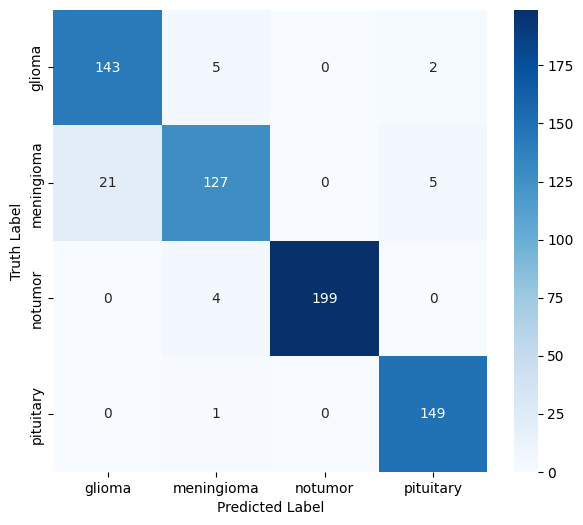

In [36]:
cm = confusion_matrix(test_generator.classes, y_pred)
class_dict = train_generator.class_indices
labels = list(class_dict.keys())
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [37]:
clr = classification_report(test_generator.classes, y_pred)
print(clr)


              precision    recall  f1-score   support

           0       0.87      0.95      0.91       150
           1       0.93      0.83      0.88       153
           2       1.00      0.98      0.99       203
           3       0.96      0.99      0.97       150

    accuracy                           0.94       656
   macro avg       0.94      0.94      0.94       656
weighted avg       0.94      0.94      0.94       656



In [38]:
!pip install pickle5


  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pickle5
Failed to build pickle5


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [15 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-310\pickle5
  copying pickle5\pickle.py -> build\lib.win-amd64-cpython-310\pickle5
  copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-310\pickle5
  copying pickle5\__init__.py -> build\lib.win-amd64-cpython-310\pickle5
  creating build\lib.win-amd64-cpython-310\pickle5\test
  copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-310\pickle5\test
  copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-310\pickle5\test
  copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-310\pickle5\test
  copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-310\pickle5\test
  running build_ext
  building 'pickle5._pickle' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with 

In [ ]:
import pickle

# Create a copy of history excluding the model
history_without_model = {key: value for key, value in history.items() if key != 'best_model'}

# Save the dictionary
with open('VGG_Resnet_d1.pkl', 'wb') as file:
    pickle.dump(history_without_model, file)




In [ ]:
# Load the history dictionary
with open('VGG_Resnet_d1.pkl', 'rb') as file:
    loaded_history = pickle.load(file)


In [41]:
loaded_history.keys()


dict_keys(['train_losses', 'train_accuracies', 'val_losses', 'val_accuracies', 'test_loss', 'test_accuracy'])

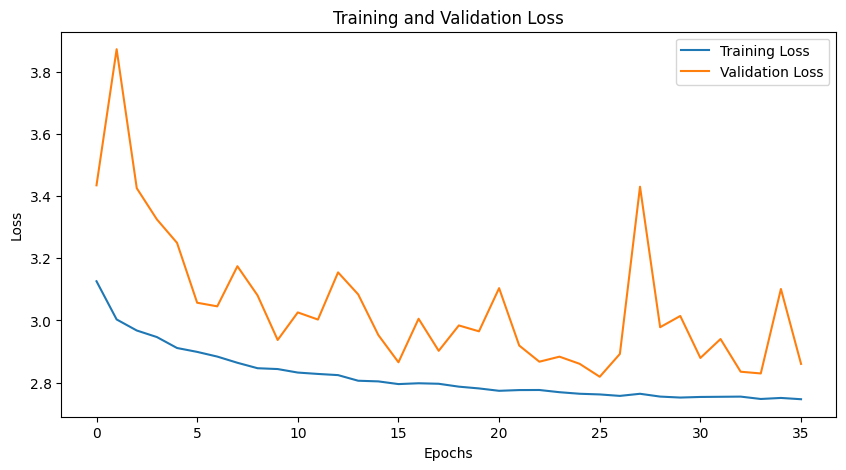

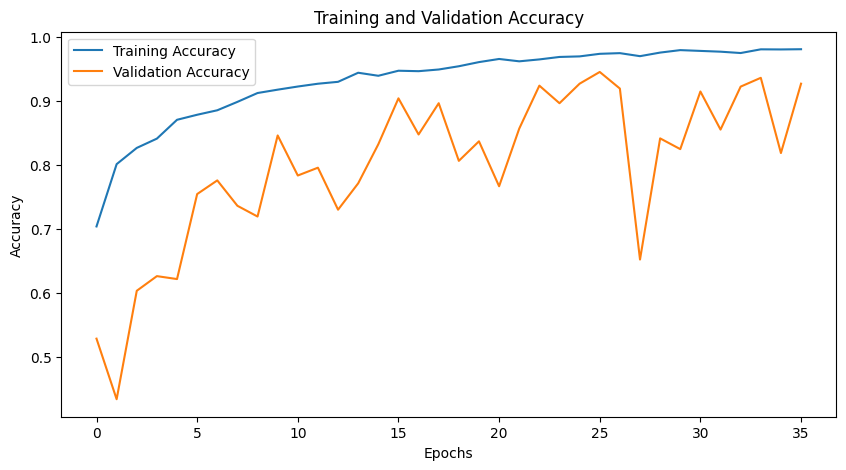

In [42]:
# Example: Plot training and validation losses
import matplotlib.pyplot as plt

# Extract losses and accuracies
train_losses = loaded_history['train_losses']
val_losses = loaded_history['val_losses']
train_accuracies = loaded_history['train_accuracies']
val_accuracies = loaded_history['val_accuracies']

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
